### How to get specific images from `DataLoaders`

**Situation:**
Below we set up two `DataBlock`'s where:
 - `dblock` contains an extra operation, `batch_tfms` *Normalizes*.
 - `dblock2` does not contain this extra operation.

We want to grab the same image from both of these (using `Dataloader.one_batch()[0][0]`). But the shuffling of idx's when data is loaded occurs differently for each of these blocks when they become dataloaders.

**Findings:**

 - in DataBlock.dataloaders() add `shuffle_train=False` to preserve order and get the same picture.
 - dataloaders automatically put away 10% of the data in validation set.


**Remaining Questions:**

 - Does this actually get the same picture?
 - How to get validation set?
 - Why don't the shuffled datasets match with same seed?
   - is it true the train / valid is the same but the order in train is different?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *
from fastai2.basics import *

##### Setup up Situation

In [3]:
path = untar_data(URLs.COCO_SAMPLE)

In [4]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

dblock2 = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   )

In [5]:
d_1_shuffled = dblock.dataloaders(path, bs=4)
d_1_ordered  = dblock.dataloaders(path, bs=4, shuffle_train=False)

d_2_shuffled = dblock2.dataloaders(path, bs=4)
d_2_ordered  = dblock2.dataloaders(path, bs=4, shuffle_train=False)

##### Controlling `shuffle` attribute

In [6]:
d_1_shuffled.shuffle, d_2_shuffled.shuffle

(True, True)

In [7]:
d_1_ordered.shuffle, d_2_ordered.shuffle

(False, False)

In [8]:
d_1_shuffled.get_idxs()[0], d_2_shuffled.get_idxs()[0]

(18052, 8327)

In [9]:
d_1_ordered.get_idxs()[0], d_2_ordered.get_idxs()[0]

(0, 0)

##### Check this works

In [10]:
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import transforms
pil_t = transforms.ToPILImage()

In [11]:
shuffled_1 = d_1_shuffled.one_batch()[0][0]
shuffled_2 = d_2_shuffled.one_batch()[0][0]
shuffled_1 = pil_t(shuffled_1.cpu())
shuffled_2 = pil_t(shuffled_2.cpu())

ordered_1 = d_1_ordered.one_batch()[0][0]
ordered_2 = d_2_ordered.one_batch()[0][0]
ordered_1 = pil_t(ordered_1.cpu())
ordered_2 = pil_t(ordered_2.cpu())

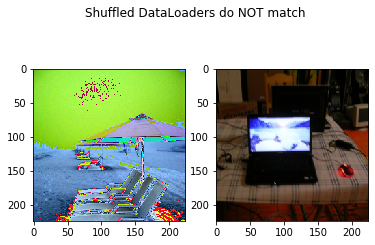

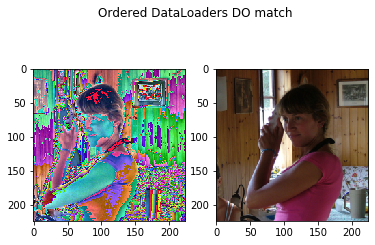

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(shuffled_1)
ax[1].imshow(shuffled_2)
fig.suptitle('Shuffled DataLoaders do NOT match');
# plt.figure(figsize=(7,7));
# plt.show();

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(ordered_1)
ax[1].imshow(ordered_2);
fig.suptitle('Ordered DataLoaders DO match');
# plt.figure(figsize=(7,7));
# plt.show();

##### How many images are there?
we look at the COCO dataset folder and find 21837 images

we look at the DataLoaders and there are 19654 samples

Assuming the default of 90% training, we backout and find an exact match

In [14]:
import os
path/'train_sample'

Path('/home/jupyter/.fastai/data/coco_sample/train_sample')

In [15]:
files = os.listdir(path/'train_sample')
len(files)

21837

In [16]:
train_files = dls.get_idxs()
len(train_files)

19654

In [17]:
len(train_files) * (1/.9)

21837.777777777777

##### How to get validation set of images?